# Project: XGBRegressor and LightGBM 

This project experiments with [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_api.html) and [LightGBM](https://lightgbm.readthedocs.io/en/stable/) and uses [scikit-optimize](https://scikit-optimize.github.io/stable/) for hyperparameter optimization. 

The dataset used is the Abalone dataset and can be found [here](https://www.kaggle.com/competitions/playground-series-s4e4/submissions).

These models will be evaluated based on their performance and the best model will be used to determine the features most important for estimating the target. In this case, the target is the number of rings on an [abalone](https://en.wikipedia.org/wiki/Abalone).  

The model training was done on a laptop using 6 cores of an Intel i5.

In [1]:
import pickle

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, mean_squared_error,
                             mean_squared_log_error)
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from skopt import BayesSearchCV

import util
from xgboost import XGBRegressor


def print_results(_results, _X_test, _y_test):
  print("Best model: %f using %s" % (np.sqrt(_results.best_score_*-1), _results.best_params_))
  print("RMSE score: %f" % ( np.sqrt(mean_squared_error(_y_test, _results.best_estimator_.predict(_X_test).ravel())) ) )
  print("RMSLE score: %f" % ( np.sqrt(mean_squared_log_error(_y_test, _results.best_estimator_.predict(_X_test))) ) )

### The data is loaded.

In [2]:
train = pd.read_csv("train.csv"); train.set_index('id',inplace=True)
test = pd.read_csv("test.csv"); test.set_index('id',inplace=True)

### EDA is performed below.

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90615 entries, 0 to 90614
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             90615 non-null  object 
 1   Length          90615 non-null  float64
 2   Diameter        90615 non-null  float64
 3   Height          90615 non-null  float64
 4   Whole weight    90615 non-null  float64
 5   Whole weight.1  90615 non-null  float64
 6   Whole weight.2  90615 non-null  float64
 7   Shell weight    90615 non-null  float64
 8   Rings           90615 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 6.9+ MB


Lets look at distirbutions.

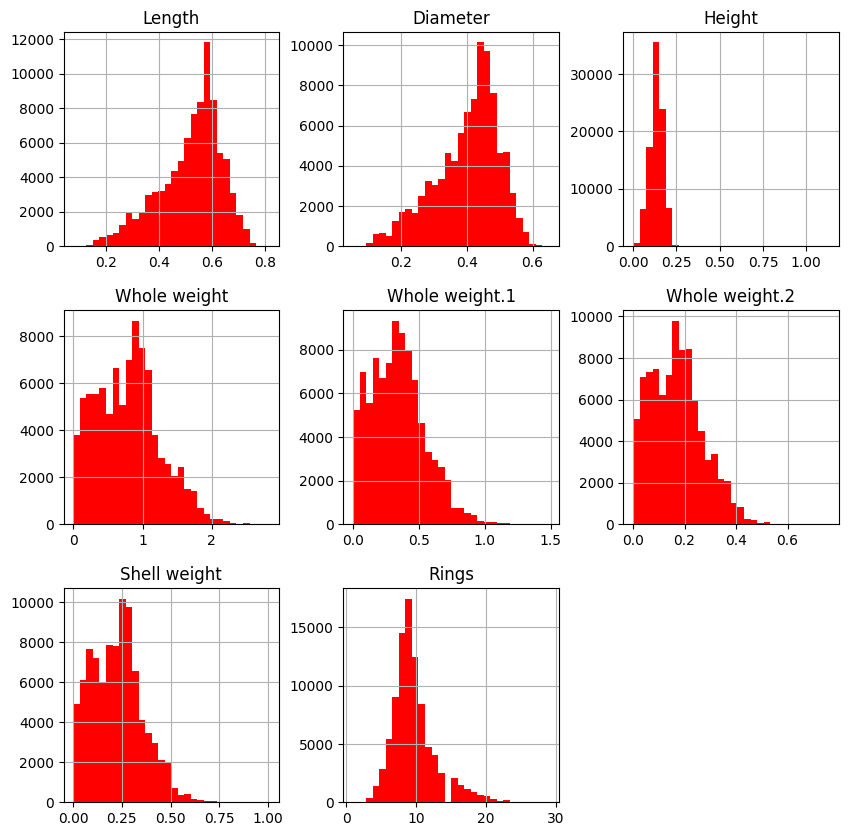

In [4]:
train.hist(bins = 30, figsize = (10,10), color = 'r');
plt.show()

It appears most of the data has a skewed normal distribution or a log-normal distribution. For the type of models being trained in this notebook, no correcting transformations are requried. 

The code below identifies the categorical and numeric featues and separates the training variables from the target.

In [3]:
# Define categorical and numerical features
y_col = ['Rings']
categorical_features = [col for col in train.select_dtypes(include=["object"]).columns.tolist() if col not in y_col]
numerical_features = [col for col in train.select_dtypes(include=["float64", "int64"]).columns.tolist() if col not in y_col]
print(categorical_features)
print(numerical_features)
trainX = train[categorical_features + numerical_features]; trainY = train[y_col]
testX = test[categorical_features + numerical_features]

['Sex']
['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']


Below are the pair-wise comparison. I scaled the data to better visualize the relationships.

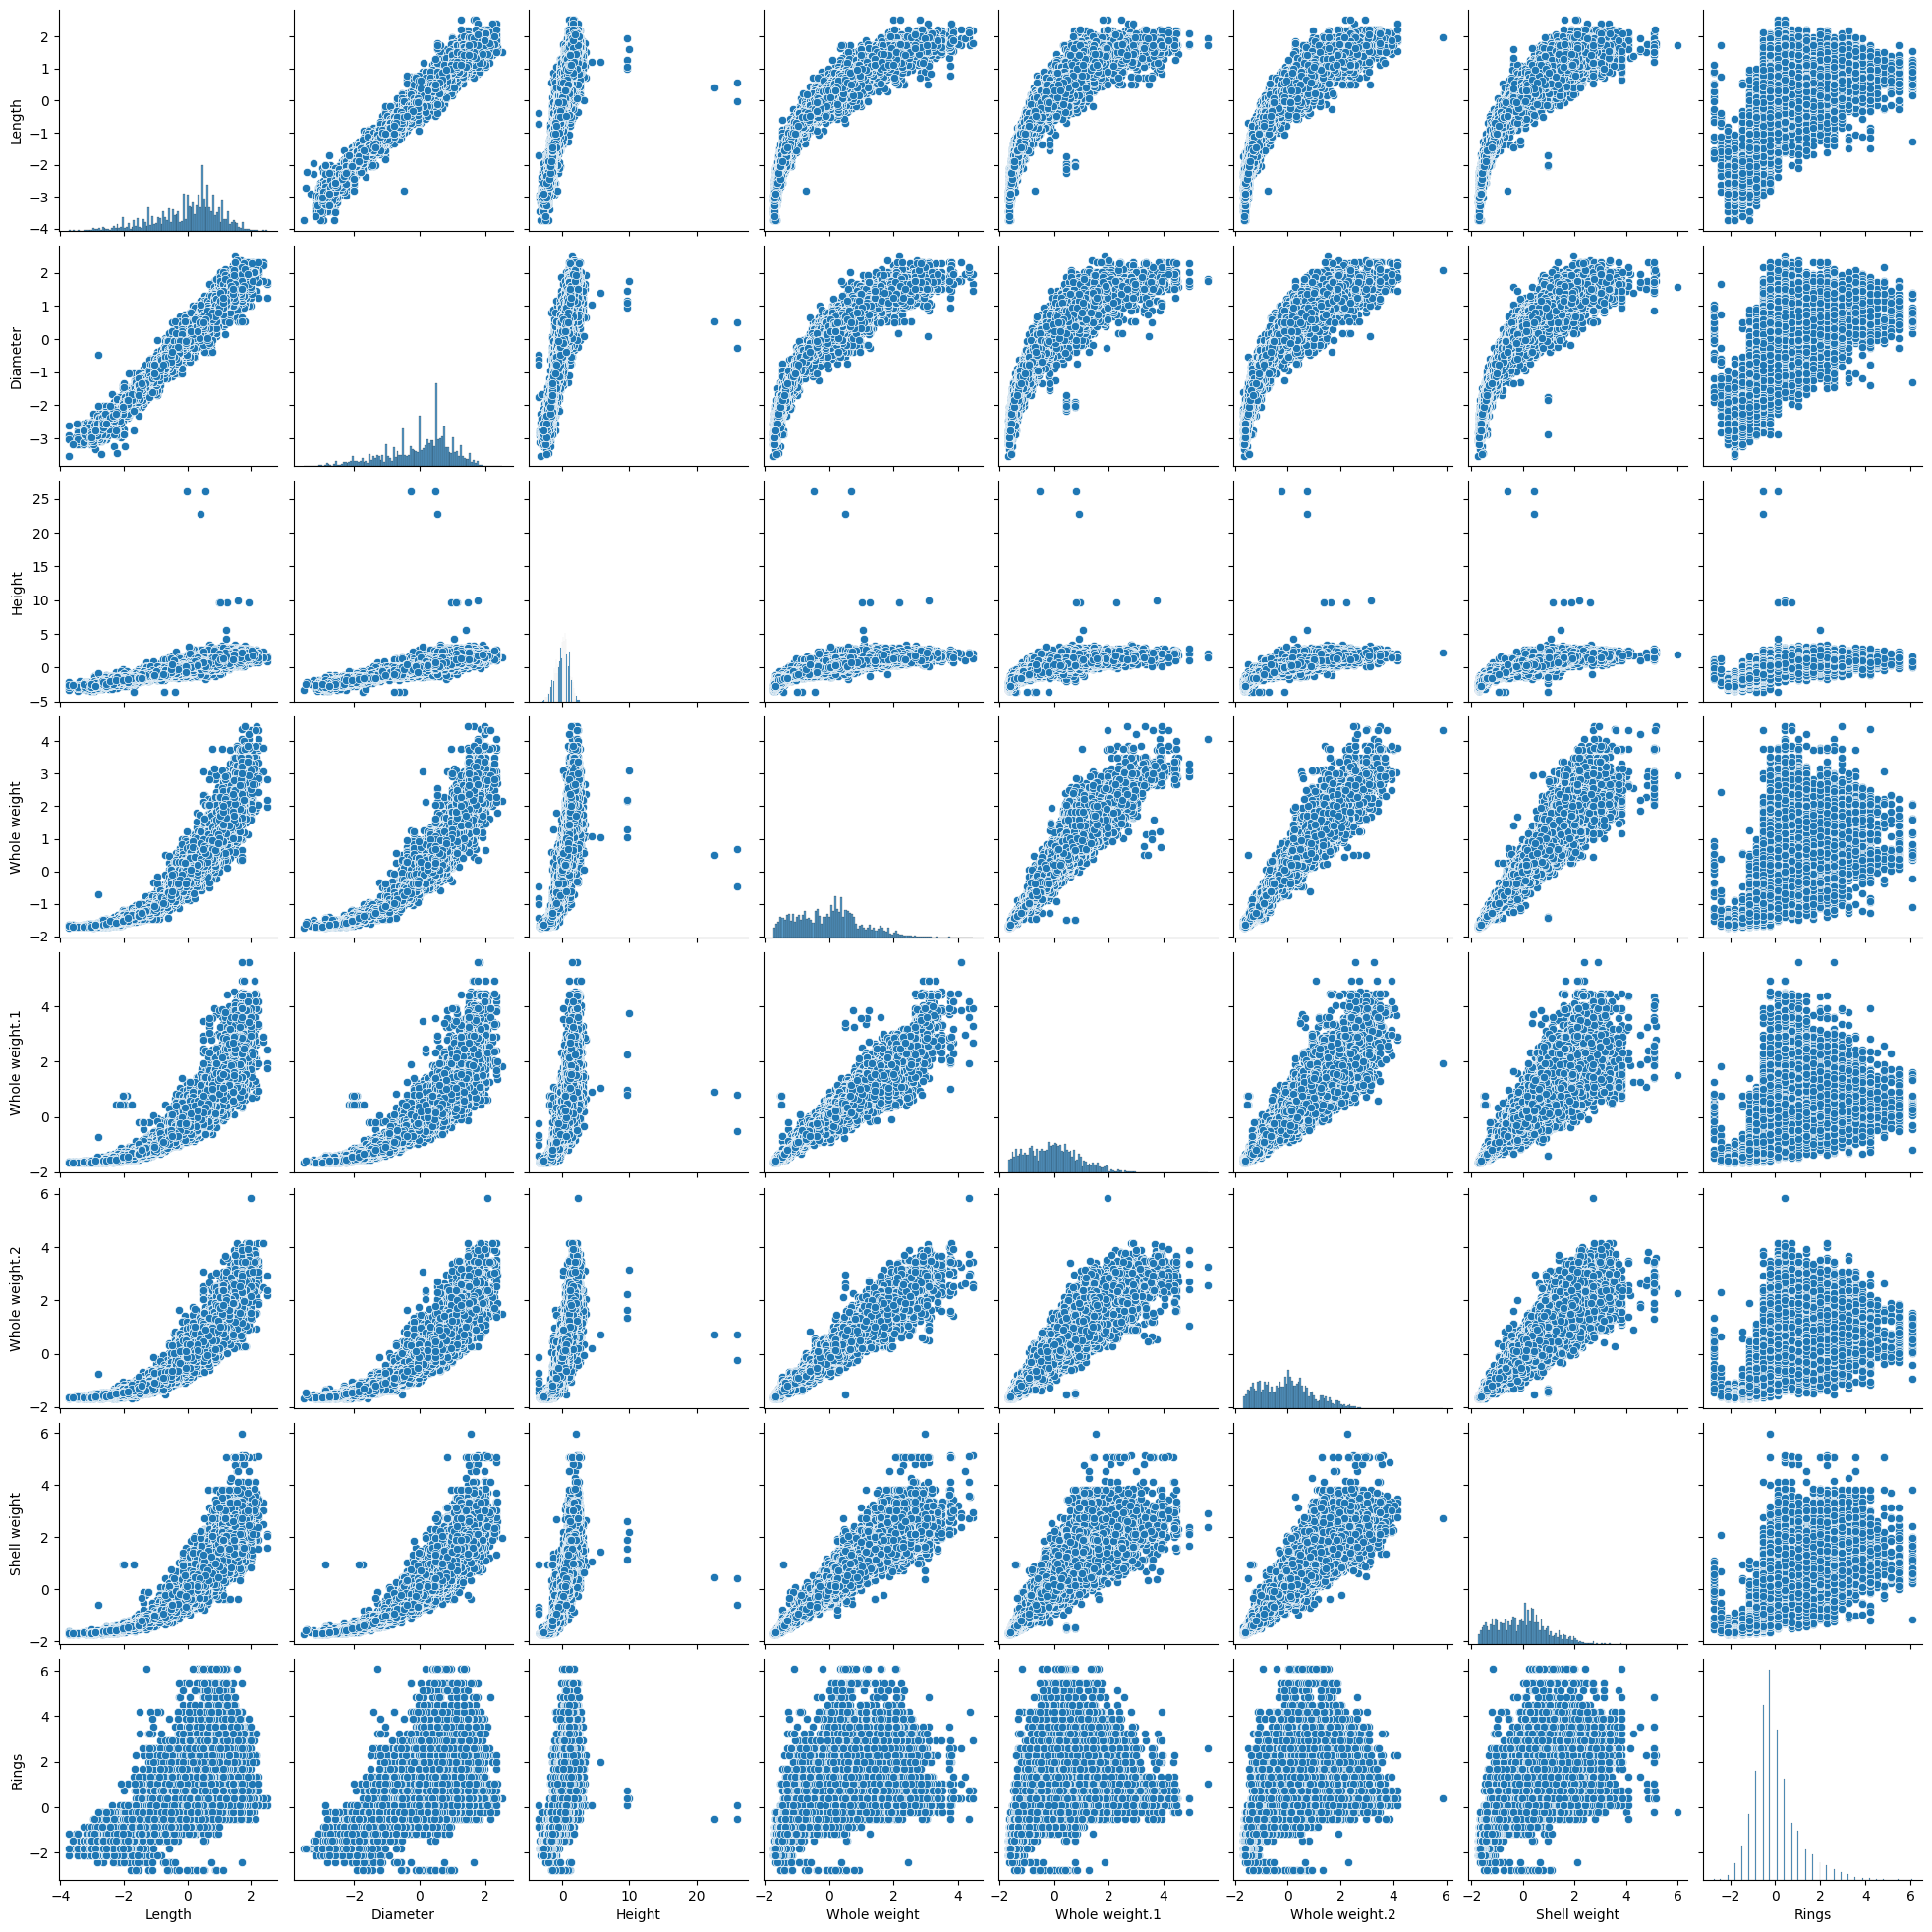

In [42]:
X_pp =  pd.DataFrame(data=StandardScaler().fit_transform(train[numerical_features + y_col]), 
                      columns=train[numerical_features + y_col].columns,
                      index=train[numerical_features + y_col].index)

g = sns.pairplot(X_pp)
plt.show()

Of note, some of the dependent variable are highly correlated, e.g. `Diameter` and `Length`. Furthermore, feature like those releated to weight seem to be capturing the same effect with regard to predicting the number of `Rings`.

Lets take a closer look at the correlations.

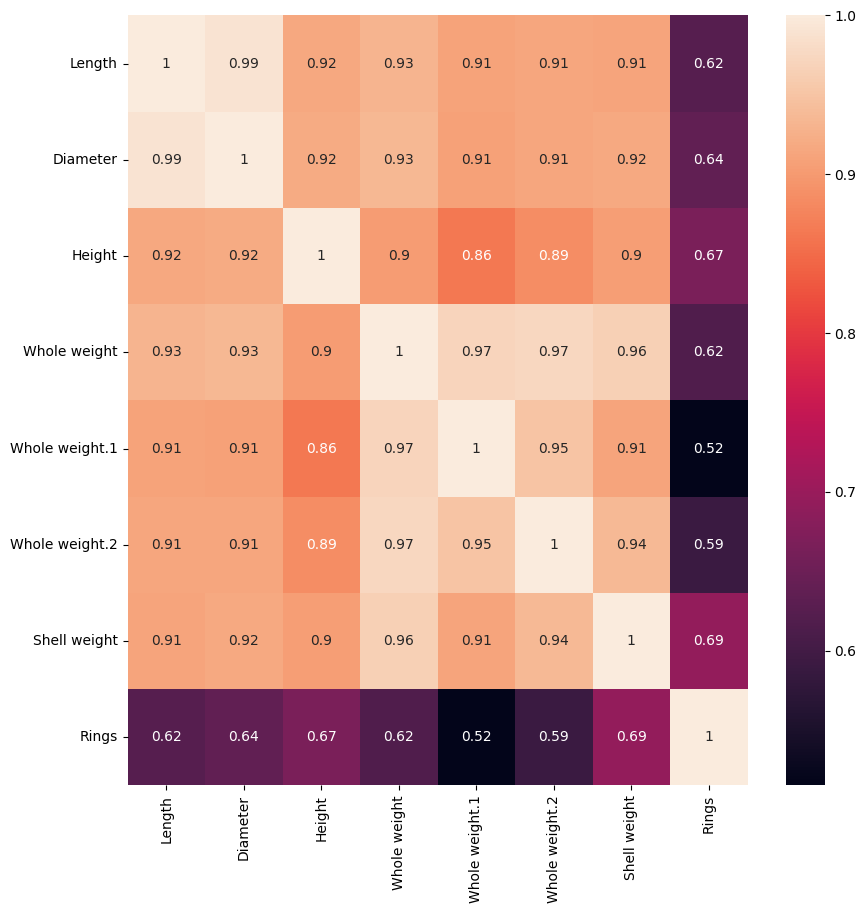

In [35]:
plt.figure(figsize=(10,10))

corr_matrix = train[numerical_features + y_col].corr()
sns.heatmap(corr_matrix, annot = True)
plt.show()

Some of the variables are highly correlated with each other. They could probably be dropped from the analysis without much loss of information. However, the decision tree based models used for the analysis don't require these correlated variables to be dropped. So for this analysis the won't be.

### Models

An XGBRegressor is modeled first. Only 5 interations are used to keep the training brief.

After the fitting, reclassification score is calculated. 

In [5]:
def fit_model(_model, _params_func, _X, _y, _categorical_features, _numerical_features):
    """A method to fit a model using BayesSearchCV.

    Returns: Results returned by a BayesSearchCV fit.
    """
    
    preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(), _categorical_features),
        ("num", StandardScaler(), _numerical_features),
    ]
    )

    pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("model", _model()),
    ]
    )

    params = _params_func()

    search = BayesSearchCV(estimator=pipeline, 
                        n_iter=5, n_points=5, cv=5, n_jobs=6, 
                        search_spaces=[(params)],
                        scoring = 'neg_mean_squared_error',
                        random_state=42, verbose=5)

    search.fit(_X[_categorical_features + _numerical_features], _y)

    return search

In [11]:
%%time
def get_xgb_model():
    return XGBRegressor(random_state=42)

search = fit_model(get_xgb_model, util.get_xgb_params, trainX, trainY, categorical_features, numerical_features)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 6min 51s
Wall time: 5min 29s


In [12]:
%%time
print_results(search, trainX, trainY)

Best model: 1.899744 using OrderedDict({'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...), 'model__colsample_bylevel': 0.682747252884433, 'model__colsample_bynode': 0.7719872187435449, 'model__colsample_bytree': 0.04099499569425203, 'model__eta': 0.9847879469544074, 'model__gamma': 45.7367781792

The root mean squared log error was 0.150774.

Next a LightGBM is modeled. Again, 5 interations are used to keep the training brief.

In [7]:
%%time
def get_lgb_model():
    return lgb.LGBMRegressor(random_state=42, verbosity=-1)

lgbr_search = fit_model(get_lgb_model, util.get_lgbc_params, trainX, trainY, categorical_features, numerical_features)
#.fit(trainX, trainY['Rings'].values.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\woshi\.virtualenvs\xgboost-EOtwD0zj\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


CPU times: total: 29.3 s
Wall time: 7min 35s


In [8]:
%%time
print_results(lgbr_search, trainX, trainY)

Best model: 1.828051 using OrderedDict({'model': LGBMRegressor(random_state=42, verbosity=-1), 'model__bagging_fraction': 0.5706795887952468, 'model__bagging_freq': 4, 'model__boosting_type': 'gbdt', 'model__class_weight': None, 'model__colsample_bytree': 0.264403740244762, 'model__feature_fraction': 0.7031253783434505, 'model__importance_type': 'split', 'model__learning_rate': 0.01461139969420763, 'model__max_depth': 10, 'model__min_child_samples': 18, 'model__min_split_gain': 0.7656274548612934, 'model__n_estimators': 895, 'model__num_leaves': 86, 'model__objective': 'regression', 'model__reg_alpha': 16.5173848745123, 'model__reg_lambda': 71.6519320916722, 'model__scale_pos_weight': 9.81689134168386, 'model__subsample': 0.8368442213309825})
RMSE score: 1.748066
RMSLE score: 0.143949
CPU times: total: 23.6 s
Wall time: 13.1 s


To prove having redundant features does not improve performance, the feature that had high correlation with other features are removed and the model fitted again. 

In [9]:
#['Sex']
trimed_num = ['Length', 'Height', 'Shell weight']
lgbr_search = fit_model(get_lgb_model, util.get_lgbc_params, trainX, trainY, categorical_features, trimed_num)
print_results(lgbr_search, trainX[categorical_features + trimed_num], trainY)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\woshi\.virtualenvs\xgboost-EOtwD0zj\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best model: 1.987398 using OrderedDict({'model': LGBMRegressor(random_state=42, verbosity=-1), 'model__bagging_fraction': 0.5706795887952468, 'model__bagging_freq': 4, 'model__boosting_type': 'gbdt', 'model__class_weight': None, 'model__colsample_bytree': 0.264403740244762, 'model__feature_fraction': 0.7031253783434505, 'model__importance_type': 'split', 'model__learning_rate': 0.01461139969420763, 'model__max_depth': 10, 'model__min_child_samples': 18, 'model__min_split_gain': 0.7656274548612934, 'model__n_estimators': 895, 'model__num_leaves': 86, 'model__objective': 'regression', 'model__reg_alpha': 16.5173848745123, 'model__reg_lambda': 71.6519320916722, 'model__scale_pos_weight': 9.81689134168386, 'model__subsample': 0.8368442213309825})
RMSE score: 1.953275
RMSLE score: 0.157950


The performance had degraded. So the highly correlated dependent variables do add value.

In the training above, the LGBM performed best. Below, 50 iteration are performed on a LGBM to see performed can be improved. 

In [ ]:
%%time
lgbr_params  = util.get_lgbc_params( lgb.LGBMRegressor(random_state=42,verbosity=-1), 'regression')

lgbr_preprocessor = ColumnTransformer(
   transformers=[
       ("cat", OneHotEncoder(), categorical_features),
       ("num", StandardScaler(), numerical_features),
   ]
)

lgbr_pipeline = Pipeline(
   [
       ("preprocessor", lgbr_preprocessor),
       ("model", lgb.LGBMRegressor(random_state=42,verbosity=-1)),
   ]
)

lgbr_search = BayesSearchCV(estimator=lgbr_pipeline, 
                       n_iter=50, n_points=5, cv=5, n_jobs=6, 
                       search_spaces=[(lgbr_params)],
                       scoring = 'neg_mean_squared_error',
                       random_state=42, verbose=2)

lgbr_search.fit(trainX, trainY['Rings'].values.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 5min 52s
Wall time: 4h 8min 18s


BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('cat',
                                                                          OneHotEncoder(),
                                                                          ['Sex']),
                                                                         ('num',
                                                                          StandardScaler(),
                                                                          ['Length',
                                                                           'Diameter',
                                                                           'Height',
                                                                           'Whole '
                                                                           'weight',
                                                                           'Whole '
                                                                           'weight.1',
                                                                           'Whole '
                                                                           'weight.2',
                                                                           'Shell '
                                                                           'weight'])])),
                                        ('model',
                                         LGBMRegressor(random_state=42,
                                                       verbosity=-1))]),
              n_jobs=6, n_points=5, random_state=42,
              scorin...
                              'model__objective': Categorical(categories=('regression',), prior=None),
                              'model__reg_alpha': Real(low=0, high=100, prior='uniform', transform='normalize'),
                              'model__reg_lambda': Real(low=0, high=100, prior='uniform', transform='normalize'),
                              'model__scale_pos_weight': Real(low=0.1, high=10.0, prior='uniform', transform='normalize'),
                              'model__subsample': Real(low=0.1, high=1.0, prior='uniform', transform='normalize')}],
              verbose=2)

In [7]:
%%time
print_results(lgbr_search, trainX, trainY)

Best model: 1.822736 using OrderedDict({'model': LGBMRegressor(random_state=42, verbosity=-1), 'model__bagging_fraction': 0.9, 'model__bagging_freq': 1, 'model__boosting_type': 'gbdt', 'model__class_weight': None, 'model__colsample_bytree': 0.3814788876254779, 'model__feature_fraction': 0.7067630980173667, 'model__importance_type': 'split', 'model__learning_rate': 0.01, 'model__max_depth': 15, 'model__min_child_samples': 14, 'model__min_split_gain': 1.0, 'model__n_estimators': 1172, 'model__num_leaves': 176, 'model__objective': 'regression', 'model__reg_alpha': 15.865146138878458, 'model__reg_lambda': 39.664378360231986, 'model__scale_pos_weight': 0.13096162700523997, 'model__subsample': 0.12131065386939723})
RMSE score: 1.677121
RMSLE score: 0.139481
CPU times: total: 31 s
Wall time: 14.9 s


The performance has improved. 

Below, the model is persisted.

In [8]:
file_name = "lgb_reg.pkl"
pickle.dump(lgbr_search.best_estimator_, open(file_name, "wb"))
xgb_model_loaded = pickle.load(open(file_name, "rb"))

Now, predictions are made using the best estimator found during the 50 iterataions of training.

In [9]:
print('Get predictions from test data...')
pred = lgbr_search.best_estimator_.predict(testX)
df_results = pd.DataFrame(data={"Rings":pred}, index=testX.index)
df_results.index.name = "id"
df_results.to_csv("lgb_reg_pred.csv")
print('Done.')

Get predictions from test data...
Done.


### Conclusions

For this experiment, LGBM had better performance then XGBoost. Furthermore, the LGBM predictions were submitted to Kaggle and the RMSLE reported for the test data was 0.14736. At the time of these experiments, the best score submitted by other participants was 0.14418. So, my model has room from improvement.

Below are the feature importances from the model ([here](https://www.geeksforgeeks.org/lightgbm-feature-importance-and-visualization/) is a reference for these plots). Due to the preprocessor in the sklearn pipeline used, the dataframe column names have been removed. But we can infer their names from the order of the original data.   

The first two columsn are for ['Sex'].
The remaining eight are for ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight'].


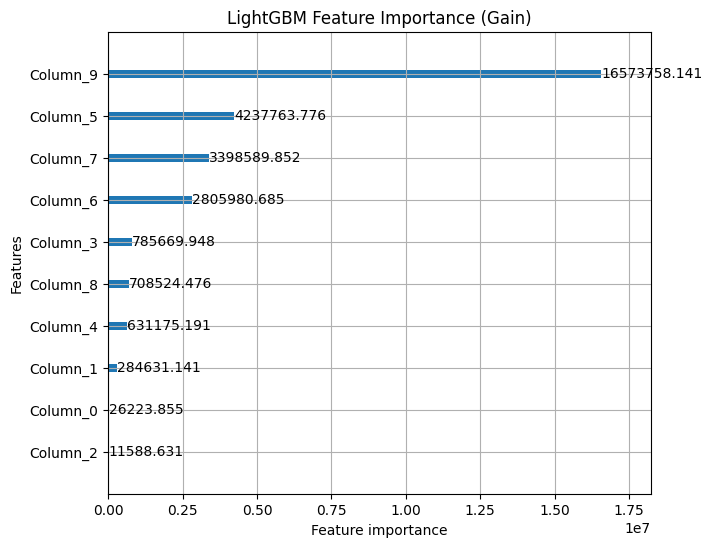

In [16]:
import pickle
import lightgbm as lgb
import matplotlib.pyplot as plt 

print(f'The first two columsn are for {categorical_features}.')
print(f'The remaining eight are for {numerical_features}.')

lgbm_model_loaded = pickle.load(open("lgb_reg.pkl", "rb"))
lgb.plot_importance(lgbm_model_loaded['model'], importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

So `Shell weight` provides the best improvement. `Sex` and `Length` are still the least important. But what do the `gain` numbers mean? An excellent explanation of how `gain` in calculated for LGBM can be found [here](https://forecastegy.com/posts/feature-importance-lightgbm-python-example/). To summarize: `gain` measures the improvement in the splitting criterion that results from using a feature in a tree’s split. For each feature, the gain is calculated as the sum of the improvements it provides across all the trees in the model, normalized by the number of splits that included the feature. This normalization ensures a fair comparison between features. For model training, I used mean squared error for the scoring. 

Another way to view feature importance is to use the `split` metric. This approach calculates feature importance by counting how many times a feature is used to split nodes across all the trees in the model. It reflects how important a feature was in making decisions.

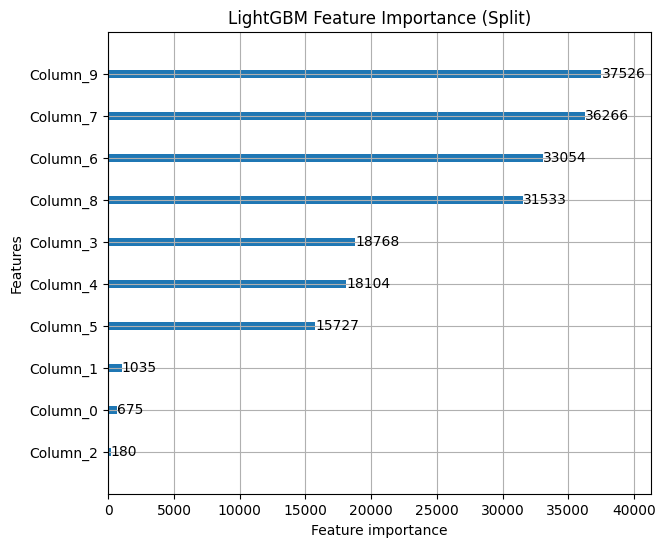

In [20]:
lgb.plot_importance(lgbm_model_loaded['model'], importance_type="split", figsize=(7,6), title="LightGBM Feature Importance (Split)")
plt.show()

`Shell weight` is still the most important feature. But the order of importance for the other features has shuffled and the difference between the most import feature and the top 4 has narrowed. However, `Sex` and `Length` are still the least important.

